In [2]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums

In [3]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [4]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [5]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [6]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [7]:
for idx_resample in range(1,1+num_resamples):
    state_mask = state_masks[idx_resample][:K-1]
    if state_mask.sum()==0: 
        print(idx_resample)

133
223
404
473


In [59]:
idx_resample = np.random.randint(500)

df = all_dfs[idx_resample]
model = all_models[idx_resample]

As = model.dynamics.As
bs = model.dynamics.bs

xs = np.vstack(list(df['continuous_states'].values))

cov = np.corrcoef(xs.T)
U,Lam,V = np.linalg.svd(cov)
pcs = U[:,:2] # using top 2 principal components
print(idx_resample)

429


[0.6770339899634163, 0.7349505663182458, 0.7941361267857745, 0.8328328402669212, 0.8609184287646954, 0.9888231077592311]


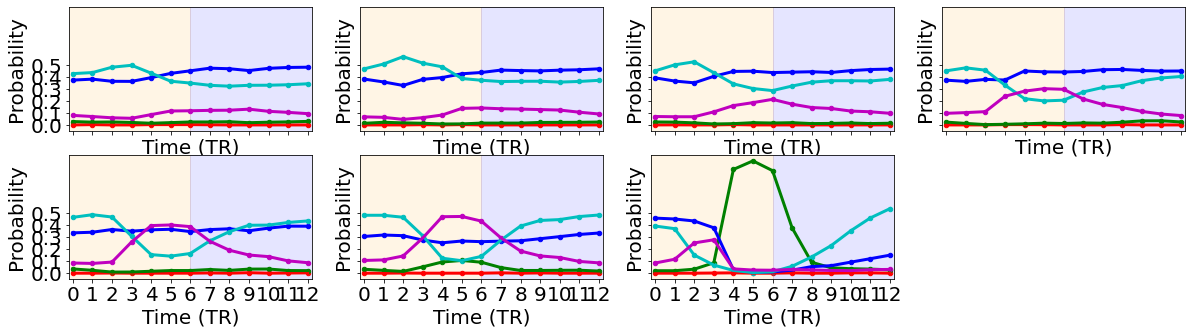

In [60]:
from scipy.signal import argrelextrema

def find_windows_and_local_maxima(values, censor, window_length, hrf_lag=3):
    local_maxima_indices = argrelextrema(values, np.greater)[0]
    windows = []
    local_maxima = []
    for idx in local_maxima_indices:
        if idx - window_length // 2 + hrf_lag >= 0 and idx + window_length // 2 + hrf_lag < len(values) :
            window_start = idx - window_length // 2 + hrf_lag
            window_end = idx + window_length // 2 + hrf_lag
            windows.append((window_start, window_end))
            local_maxima.append(values[idx])
    return windows, local_maxima

def get_x_prox(df):
    local_maxima_all = []
    windows_all = []
    states_all_windows = []
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        censor = df.loc[idx_row]['censor'][:,0]
        xs = df.loc[idx_row]['continuous_states']
        states = df.loc[idx_row]['discrete_states']
        window_length = 12
        windows, local_maxima = find_windows_and_local_maxima(prox, censor, window_length)
        local_maxima_all += local_maxima
        windows_all += windows
        states_all_windows += [states[l:r+1] for l,r in windows]
    states_all_windows = np.vstack(states_all_windows)
    local_maxima_all = np.array(local_maxima_all)
    return states_all_windows, local_maxima_all

states_all_windows, local_maxima_all = get_x_prox(df)
colors = 'rgbcmyk'
state_names = [f'State{i+1}' for i in range(K)]
ncols=4
local_maxima_bins = [np.quantile(local_maxima_all,i) for i in np.arange(0,1,1/7)[1:]]
print(local_maxima_bins)
bin_indices = np.digitize(local_maxima_all,bins=local_maxima_bins)
fig,axs = plt.subplots(nrows=2, ncols=4, figsize=(20,5), sharex=True, sharey=True)
for i_bin in range(len(local_maxima_bins)+1):
    ax = axs[i_bin//ncols][i_bin%ncols]
    # find states coresponding to all windows belonging to that bin
    z_bin = states_all_windows[bin_indices==i_bin,:]
    state_window_probs = np.stack(
        [np.array([(z_bin[:,tr]==k).sum() for k in range(model.K)])
          for tr in range(z_bin.shape[1])]
          ,axis=1)
    state_window_probs = state_window_probs / state_window_probs.sum(axis=0)
    
    ax.axvspan(-1,6,alpha=0.1, color='orange')
    ax.axvspan(6,13,alpha=0.1, color='blue')
    for k in [0,1,2,3,4]:
        ax.plot(state_window_probs[k,:],color=colors[k],label=state_names[k],linewidth=3)
        ax.scatter(np.arange(z_bin.shape[1]),state_window_probs[k,:],color=colors[k],s=20)
    ax.set_xticks(np.arange(z_bin.shape[1]))
    ax.set_xticklabels(np.arange(z_bin.shape[1]),fontsize=20,rotation=0)
    ax.set_yticks(0.1*np.arange(6))
    ax.set_xlim([0-0.2,z_bin.shape[1]-1+0.2])
    # ax.set_ylim([0,0.5])
    ax.set_ylabel('Probability',fontsize=20)
    ax.set_xlabel('Time (TR)',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    min_prox = min(local_maxima_all[bin_indices==i_bin])
    max_prox = max(local_maxima_all[bin_indices==i_bin])
    # ax.set_title(f'max proximity $\in$ ({min_prox:.02f},{max_prox:.02f}) ',fontsize=12)
patchs = []
for state_name,color in zip(state_names,colors):
    if state_name in ["approach"]:
        patchs.append(mpatches.Patch(color=color, label=state_name))
fig.delaxes(axs[1][ncols-1])
axs[1][ncols-1].legend(handles=patchs,fontsize=20,ncol=1,loc='right')#,bbox_to_anchor=(1.6, 0.5))
fig.savefig(f'figures/fig_approach_retreat_state_count_K{model.K}.jpeg',dpi=600,bbox_inches='tight')